<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/cGAN_1(unconditional_DCGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import fashion_mnist

In [2]:
(train_images, train_labels), (test_images, test_labels)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


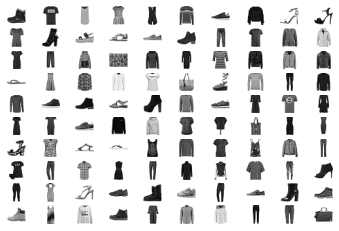

In [3]:
import matplotlib.pyplot as plt
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.axis('off')
  plt.imshow(train_images[i], cmap='gray_r')

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Input, LeakyReLU, Dropout, Dense, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

In [5]:
def build_discriminator():
  inp=Input(shape=(28, 28, 1))
  l1=Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same')(inp)
  l1=LeakyReLU(alpha=0.2)(l1)
  l2=Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same')(l1)
  l2=LeakyReLU(alpha=0.2)(l2)
  f=Flatten()(l2)
  d=Dropout(0.4)(f)
  lf=Dense(1, activation='sigmoid')(d)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model=Model(inputs=inp, outputs=lf)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [6]:
disc=build_discriminator()
disc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0     

In [7]:
def build_generator(latent_dim):
  model=Sequential()
  n=128*7*7
  model.add(Dense(n, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, kernel_size=(7,7), activation='tanh', padding='same'))
  return model

In [8]:
gen=build_generator(4)
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              31360     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0

In [9]:
def build_gan(latent_dim):
  inp=Input(shape=latent_dim)
  g=gen(inp)
  d=disc(g)
  model=Model(inputs=inp, outputs=d)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [10]:
gan=build_gan(4)

In [11]:
gan.summary()
disc.trainable=False

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         562177    
_________________________________________________________________
model (Functional)           (None, 1)                 155137    
Total params: 717,314
Trainable params: 717,314
Non-trainable params: 0
_________________________________________________________________


In [12]:
import numpy as np 

In [13]:
X=np.expand_dims(train_images, axis=-1)
X.shape, train_images.shape #expanding to 3d

((60000, 28, 28, 1), (60000, 28, 28))

In [14]:
X=(X-127.5)/127.5 #normalize

In [15]:
def generate_real_samples(n_samples):
  ix=np.random.randint(0,X.shape[0],n_samples)
  x=X[ix]
  y=np.ones((n_samples,1))
  return x,y

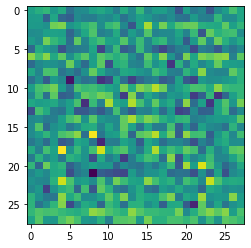

In [16]:
plt.imshow(gen.predict(np.array([1,2,3,4]).reshape(1,4)).reshape(28,28))

[[0.99285614]]


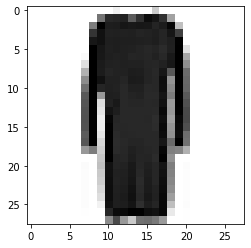

In [17]:
print(disc.predict(train_images[25].reshape(1,28,28,1)))
plt.imshow(train_images[25], cmap='gray_r')

In [18]:
x,y=generate_real_samples(25)

In [19]:
x.shape,y.shape

((25, 28, 28, 1), (25, 1))

In [20]:
def generate_latent_points(latent_dim, n_samples):
  x_in=np.random.randn(latent_dim*n_samples)
  return(x_in.reshape(n_samples, latent_dim))
def generate_fake_samples(n_samples):
  x_in=generate_latent_points(4, n_samples)
  x=gen.predict(x_in)
  y=np.zeros((n_samples,1))
  return x,y

In [21]:
x,y=generate_fake_samples(25)
x.shape, y.shape

((25, 28, 28, 1), (25, 1))

In [30]:
def train(n_epochs=100, n_batch=128):
  bat_per_epoch=X[0].shape[0]//n_batch
  half_batch=n_batch//2
  for i in range(n_epochs):
    for j in range(bat_per_epoch):
      x_real, y_real=generate_real_samples(n_samples=half_batch)
      x_fake, y_fake=generate_fake_samples(n_samples=half_batch)
      d_loss1,_ =disc.train_on_batch(x_real, y_real)
      d_loss2,_ =disc.train_on_batch(x_fake, y_fake)
      x_gan=generate_latent_points(4, n_samples=n_batch)
      y_gan=np.ones(shape=(n_batch,1))
      gan_loss,_ =gan.train_on_batch(x_gan, y_gan)
      print('%d %d,d1=%.3f,d2=%.3f,g=%.3f'%(i+1, j+1, d_loss1, d_loss2, gan_loss))

In [31]:
train(n_epochs=5)

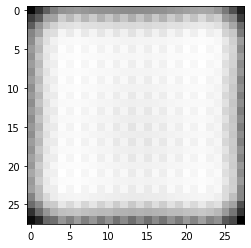

In [27]:
plt.imshow(gen.predict(np.array([.1,.2,.3,.4]).reshape(1,4)).reshape(28,28), cmap='gray_r')